## Rep Table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # HP filter and OLS regression
import datetime
import subprocess
from datetime import datetime as dt
import matplotlib.dates as mdates
import importlib
from pandas_datareader.fred import FredReader


In [2]:
import data_load_table

Load Data

In [3]:
series = data_load_table.get_fred_data('Q','own_def')

View Series

In [4]:
series = series.loc['1985-3-31':'2017-12-31']
series.tail()
series

,Y,C,G,I,N,CO,D,W_median,W_average,W_manu,Pi,i,tax,GD,BK,Piw_average,Piw_manu,BG_Y
date,,,,,,,,,,,,,,,,,,
1985-03-31,8400.820,5321.159,2120.284,1169.416,96572.333333,0.82,551.452,314.0,8.636667,9.293333,49.543333,8.476667,353.018,1710731.0,NaN,0.699572,1.161103,203.638573
1985-06-30,8474.787,5370.011,2167.338,1189.334,97269.666667,0.97,571.290,323.0,8.710000,9.370000,49.945000,7.923333,307.582,1774640.0,NaN,0.849093,0.824964,209.402313
1985-09-30,8604.220,5472.014,2216.743,1181.226,97844.333333,1.15,592.622,320.0,8.766667,9.430000,50.337000,7.900000,340.030,1823103.0,NaN,0.650593,0.640342,211.884750
1985-12-31,8668.188,5483.866,2225.878,1224.763,98428.333333,1.28,610.574,320.0,8.823333,9.500000,50.687667,8.103333,345.182,1945942.0,NaN,0.646388,0.742312,224.492362
1986-03-31,8749.127,5531.807,2243.464,1224.404,98837.666667,1.35,624.425,321.0,8.873333,9.556667,51.046667,7.826667,341.825,1986816.0,NaN,0.566679,0.596491,227.087343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,19304.352,13060.061,3389.649,3391.749,145222.333333,2.11,3636.436,349.0,21.726667,20.600000,98.946667,0.450000,1574.500,19976827.0,178353.0,0.570900,0.308391,1034.835409
2017-03-31,19398.343,13160.475,3380.244,3382.703,145820.000000,2.19,3685.787,352.0,21.843333,20.653333,99.524000,0.700000,1579.976,19846420.0,195516.0,0.536975,0.258900,1023.098725
2017-06-30,19506.949,13225.743,3389.811,3435.929,146383.333333,2.11,3727.037,354.0,21.973333,20.796667,99.724333,0.950000,1600.122,19844554.0,203976.0,0.595147,0.693996,1017.306909


Apply HP filter

In [5]:
# Initialize dictionaries to store the cycle and trend components
cycle_components = {}
trend_components = {}

for name, data in series.items():
    # Apply the HP filter to each series
    cycle, trend = sm.tsa.filters.hpfilter(np.log(data).dropna(), 1600)
    
    # Store the cycle and trend components in their respective dictionaries
    cycle_components[name + '_cycle'] = cycle
    trend_components[name + '_trend'] = trend



/Users/awellman/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Create table

In [6]:
# Specify which components to use for each variable in your analysis
# Format: 'variable_name': ('dictionary_name', 'key_in_that_dictionary')
analysis_selection = {
    'Y': ('cycle_components', 'Y_cycle'),
    'C': ('cycle_components', 'C_cycle'),
    'G': ('cycle_components', 'G_cycle'),
    'I': ('cycle_components', 'I_cycle'),
    'N': ('cycle_components', 'N_cycle'),
    'BK': ('cycle_components', 'BK_cycle'),
    'CO': ('cycle_components', 'CO_cycle'),
    'D_cycle': ('cycle_components', 'D_cycle'),
    'D_trend': ('trend_components', 'D_trend'),
    'W_ave': ('cycle_components', 'W_average_cycle'),
    'W_med': ('cycle_components', 'W_median_cycle'),
    'W_manu': ('cycle_components', 'W_manu_cycle'),
    'Pi': ('trend_components', 'Pi_trend'),
    'i': ('series', 'i'),
    'Piw_ave': ('cycle_components', 'Piw_average_cycle'),
    'tax': ('cycle_components', 'tax_cycle'),
    'BG/Y': ('cycle_components', 'BG_Y_cycle'),
    # Add more as needed
}

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Var', 'Std Dev', 'Cor(y, x)', 'Cor(x, x_t-1)'])

# Perform analysis based on the specified components
for name, (dict_name, key) in analysis_selection.items():
    # Dynamically access the appropriate dictionary and data based on the selection
    data = globals()[dict_name][key]
    
    std_dev = data.std()
    cor_y_x = data.corr(cycle_components['Y_cycle']) if 'Y_cycle' in cycle_components else None
    cor_x_xt_minus_1 = data.corr(data.shift(1))
    
    # Append the results
    new_row = pd.DataFrame({
        'Var': [name],
        'Std Dev': [std_dev],
        'Cor(y, x)': [cor_y_x],
        'Cor(x, x_t-1)': [cor_x_xt_minus_1]
    })
    
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Round the DataFrame for display
results_df = results_df.round(3)

# Display the DataFrame
results_df

/var/folders/cj/jxhf4_2j2cd0fqn86jgn30k80000gs/T/ipykernel_38072/2890107069.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


,Var,Std Dev,"Cor(y, x)","Cor(x, x_t-1)"
0,Y,0.010,1.000,0.880
1,C,0.009,0.883,0.876
2,G,0.012,-0.420,0.848
3,I,0.054,0.894,0.872
4,N,0.011,0.808,0.960
5,BK,0.208,-0.459,0.566
6,CO,0.173,-0.619,0.871
7,D_cycle,0.025,0.283,0.931
8,D_trend,0.574,0.019,1.000
9,W_ave,0.005,-0.200,0.951


In [7]:


# Perform analysis based on the specified components

auto_df = pd.DataFrame(columns=['Var', 'Std Dev', '-3', '-2', '-1', '0', '1', '2', '3'])


for name, (dict_name, key) in analysis_selection.items():
    # Dynamically access the appropriate dictionary and data based on the selection
    data = globals()[dict_name][key]
    
    std_dev = data.std()

    auto_negthree = data.corr(data.shift(-3))
    auto_negtwo = data.corr(data.shift(-2))
    auto_negone = data.corr(data.shift(-1))
    auto_zero = data.corr(data.shift(0))
    auto_one = data.corr(data.shift(1))
    auto_two = data.corr(data.shift(2))
    auto_three = data.corr(data.shift(3))

    
    # Append the results
    new_row = pd.DataFrame({
        'Var': [name],
        'Std Dev': [std_dev],
        '-3': [auto_negthree],
        '-2': [auto_negtwo],
        '-1': [auto_negone],
        '0': [auto_zero],
        '1': [auto_one],
        '2': [auto_two],
        '3': [auto_three]
    })
    
    auto_df = pd.concat([auto_df, new_row], ignore_index=True)


/var/folders/cj/jxhf4_2j2cd0fqn86jgn30k80000gs/T/ipykernel_38072/1702774189.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auto_df = pd.concat([auto_df, new_row], ignore_index=True)


In [8]:
auto_df=auto_df.round(3)

In [9]:
with open(f'/Users/awellman/Documents/SIEPR/GitHub/macrodata-wellman/check_t/table_auto.tex', 'w') as f:
    f.write(auto_df.to_latex(index=False, float_format="%.3f"))

with open(f'/Users/awellman/Documents/SIEPR/GitHub/macrodata-wellman/check_t/table_results.tex', 'w') as f:
    f.write(results_df.to_latex(index=False, float_format="%.3f"))

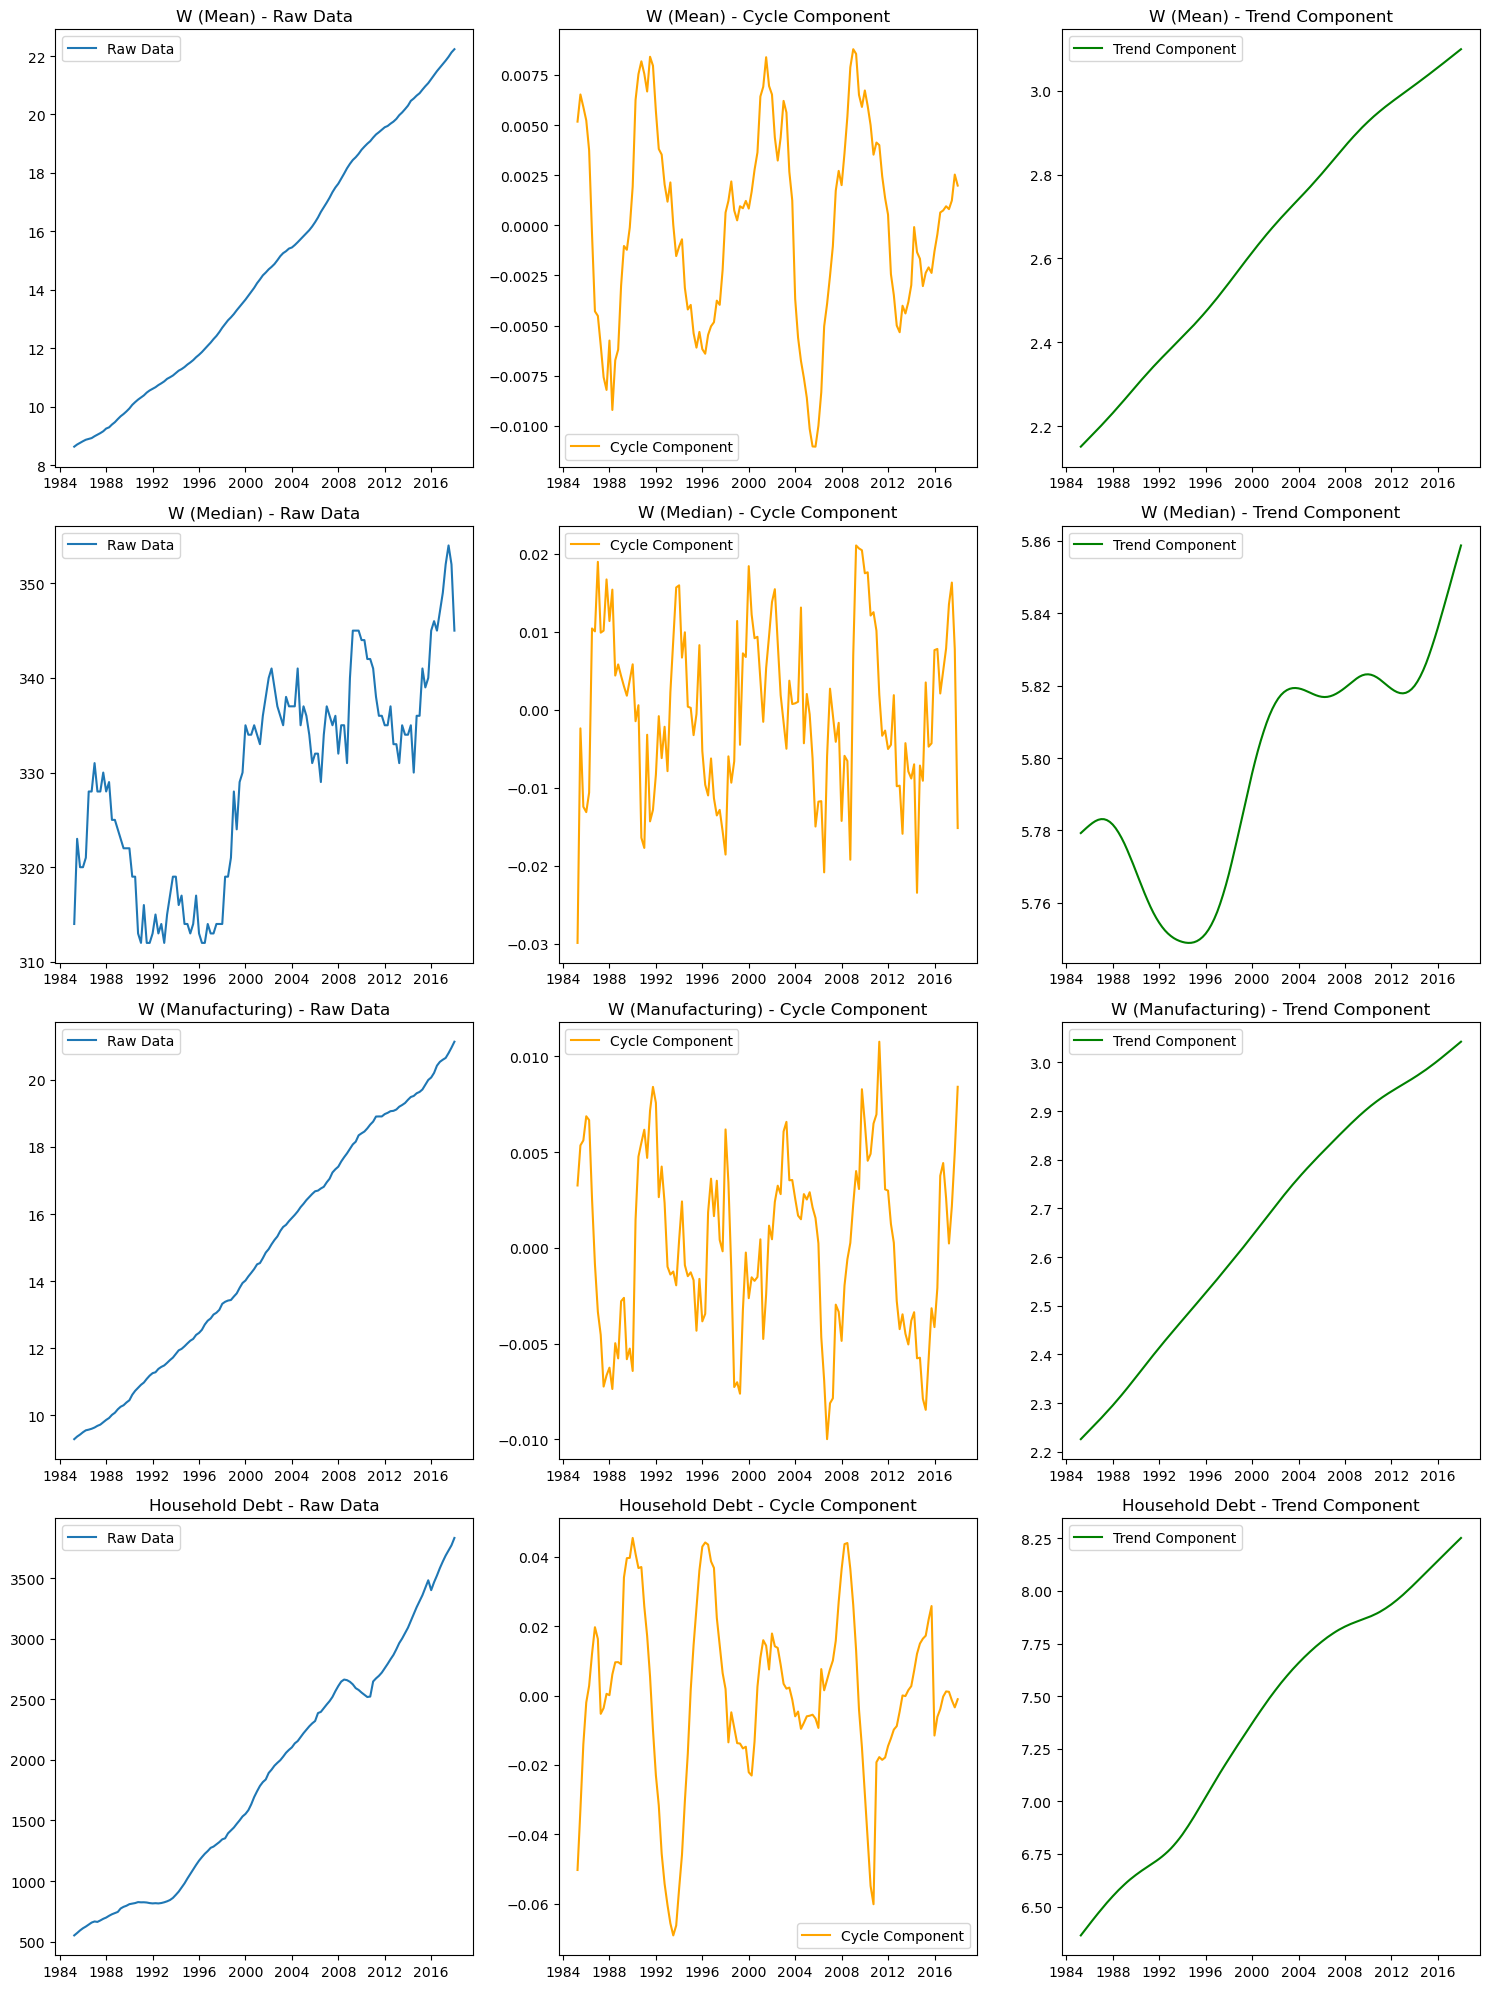

In [14]:
import matplotlib.pyplot as plt

# Define the variables to plot with their professional titles
variables_to_plot = {'W_average': 'W (Mean)', 'W_median': 'W (Median)', 'W_manu': 'W (Manufacturing)', 'D': 'Household Debt'}

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(variables_to_plot), ncols=3, figsize=(15, 5*len(variables_to_plot)))

# Plot each variable
for i, (variable, title) in enumerate(variables_to_plot.items()):
    # Plot raw data
    axes[i, 0].plot(series[variable], label='Raw Data')
    axes[i, 0].set_title(f'{title} - Raw Data')
    axes[i, 0].legend()
    
    # Plot cycle component
    axes[i, 1].plot(cycle_components[variable + '_cycle'], label='Cycle Component', color='orange')
    axes[i, 1].set_title(f'{title} - Cycle Component')
    axes[i, 1].legend()
    
    # Plot trend component
    axes[i, 2].plot(trend_components[variable + '_trend'], label='Trend Component', color='green')
    axes[i, 2].set_title(f'{title} - Trend Component')
    axes[i, 2].legend()

# Adjust layout
plt.tight_layout()

# Save the plot as an image file
plt.savefig('variable_plots.png')

# Show the plot
plt.show()
